In [6]:
# BigMart Sales Prediction Solution
# --------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [7]:

# 1. Data Loading
print("Loading the datasets...")
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display basic information
print("\nTraining data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Loading the datasets...

Training data shape: (8523, 12)
Test data shape: (5681, 11)


In [8]:
# 2. Exploratory Data Analysis
print("\n== Exploratory Data Analysis ==")

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())


== Exploratory Data Analysis ==

Missing values in training data:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [9]:
# Descriptive statistics
print("\nDescriptive statistics of numerical features:")
print(train_data.describe())


Descriptive statistics of numerical features:
       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800 

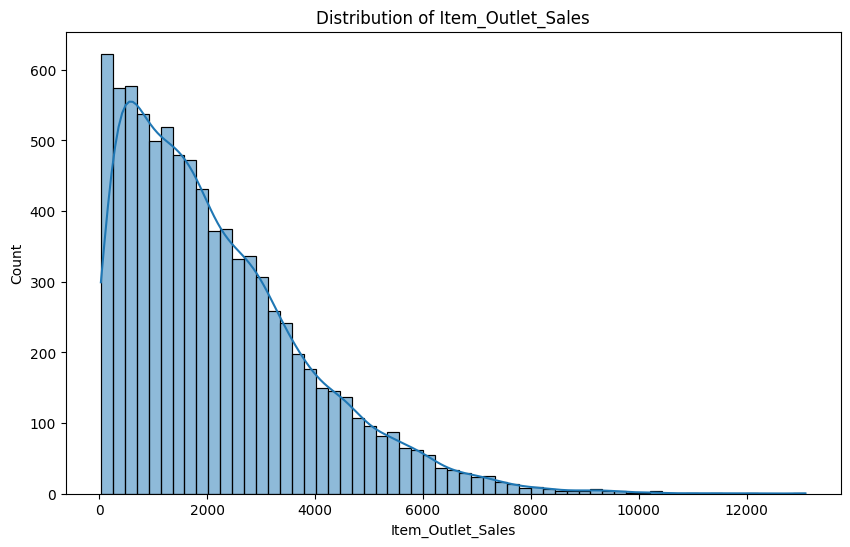

In [11]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Item_Outlet_Sales'], kde=True)
plt.title('Distribution of Item_Outlet_Sales')
plt.savefig('sales_distribution.png')
#plt.close()

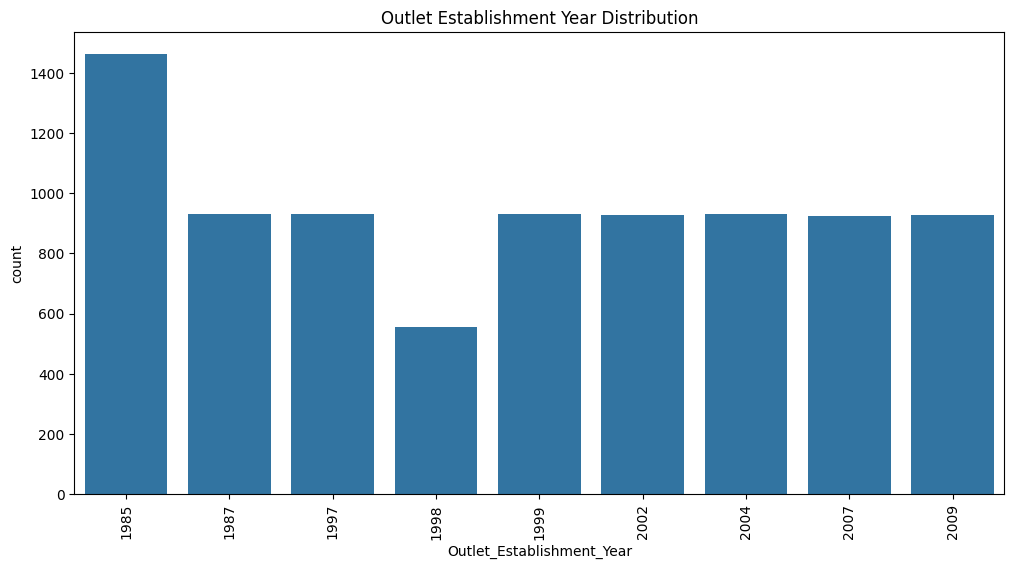

In [12]:
# Outlet establishment year distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Outlet_Establishment_Year', data=train_data)
plt.title('Outlet Establishment Year Distribution')
plt.xticks(rotation=90)
plt.savefig('establishment_year_dist.png')
#plt.close()

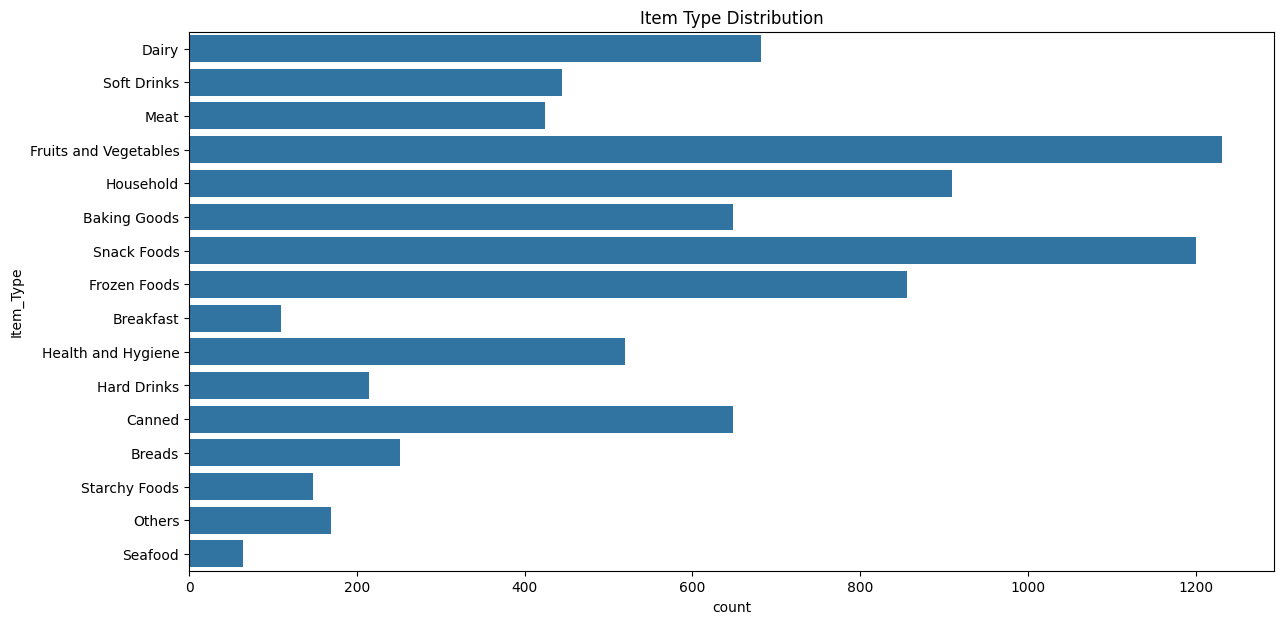

In [13]:
# Item type distribution
plt.figure(figsize=(14, 7))
sns.countplot(y='Item_Type', data=train_data)
plt.title('Item Type Distribution')
plt.savefig('item_type_dist.png')
#plt.close()

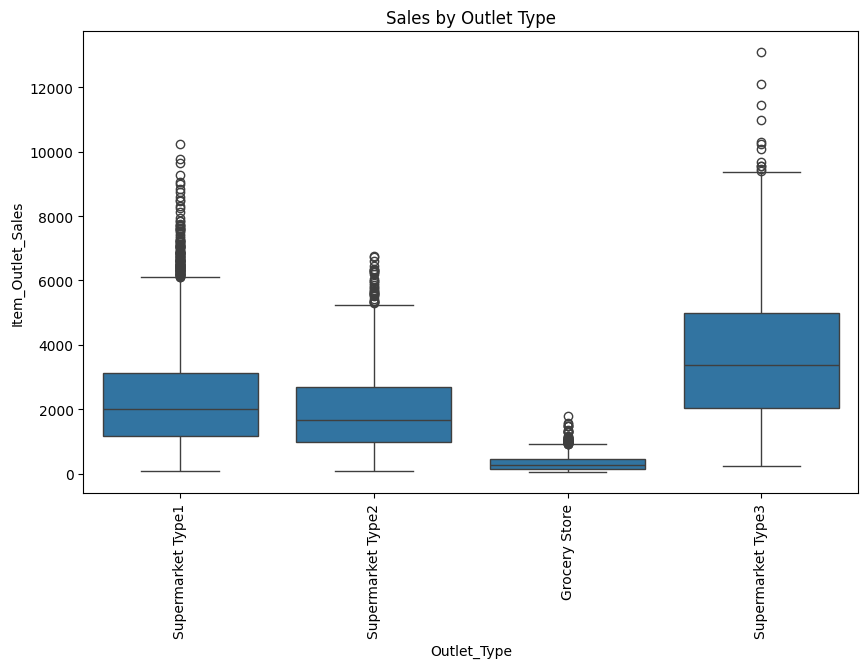

In [14]:
# Sales by outlet type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=train_data)
plt.title('Sales by Outlet Type')
plt.xticks(rotation=90)
plt.savefig('sales_by_outlet_type.png')
#plt.close()

In [15]:
# 3. Data Preprocessing
print("\n== Data Preprocessing ==")

# Combine train and test for preprocessing
df = pd.concat([train_data, test_data], ignore_index=True)
df['source'] = ['train']*len(train_data) + ['test']*len(test_data)


== Data Preprocessing ==


In [16]:

# Handle missing values
print("\nHandling missing values...")

# Item_Weight - impute with median
weight_median = df[df['Item_Weight'].notnull()]['Item_Weight'].median()
df['Item_Weight'].fillna(weight_median, inplace=True)


Handling missing values...


In [17]:

# Outlet_Size - fill with mode per outlet type
df['Outlet_Size'].fillna('Missing', inplace=True)

In [18]:
# Feature Engineering
print("\nPerforming feature engineering...")

# 1. Clean Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 
                                                         'reg': 'Regular'})


Performing feature engineering...


In [19]:
# 2. Create year operation feature
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']

# 3. Item_Visibility - Replace 0 values with mean per product type
zero_visibility = df['Item_Visibility'] == 0
for item_type in df['Item_Type'].unique():
    item_mean_visibility = df[(df['Item_Type'] == item_type) & (df['Item_Visibility'] > 0)]['Item_Visibility'].mean()
    df.loc[(zero_visibility) & (df['Item_Type'] == item_type), 'Item_Visibility'] = item_mean_visibility

In [20]:

# 4. Item price category
df['Item_MRP_Binned'] = pd.qcut(df['Item_MRP'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 5. Item type category - simplify categories
item_type_dict = {
    'Breads': 'Food',
    'Breakfast': 'Food',
    'Canned': 'Food',
    'Dairy': 'Food',
    'Frozen Foods': 'Food',
    'Fruits and Vegetables': 'Food',
    'Hard Drinks': 'Drinks',
    'Health and Hygiene': 'Non-Consumable',
    'Household': 'Non-Consumable',
    'Meat': 'Food',
    'Others': 'Non-Consumable',
    'Seafood': 'Food',
    'Snack Foods': 'Food',
    'Soft Drinks': 'Drinks',
    'Starchy Foods': 'Food'
}

In [21]:
df['Item_Category'] = df['Item_Type'].apply(lambda x: item_type_dict.get(x, 'Other'))

# Label encoding for categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 
                    'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 
                    'Item_MRP_Binned', 'Item_Category']


Encoding categorical variables...


In [22]:
label_encoders = {}
for column in categorical_cols:
    le = LabelEncoder()
    df[column + '_Encoded'] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [23]:
# One-hot encoding for selected variables
ohe_features = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category']
for feature in ohe_features:
    encoded_features = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
    df = pd.concat([df, encoded_features], axis=1)

In [24]:
# Split data back to train and test
train_processed = df[df['source'] == 'train'].drop('source', axis=1)
test_processed = df[df['source'] == 'test'].drop('source', axis=1)

In [25]:
# 4. Feature Selection
print("\n== Feature Selection ==")

# Exclude identifiers and target from features
exclude_cols = ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales', 'source', 'Item_Type', 'Item_Fat_Content',
               'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_MRP_Binned', 'Item_Category']
numerical_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Years']
categorical_features = [col for col in train_processed.columns 
                        if col.endswith('_Encoded') or '_' in col and not col.startswith('Item_') and not col.startswith('Outlet_')]


== Feature Selection ==


In [26]:

# Final feature set
features = numerical_features + categorical_features
features = [f for f in features if f in train_processed.columns and f not in exclude_cols]

In [27]:


print(f"Selected {len(features)} features for modeling.")

# Prepare training data
X = train_processed[features]
y = train_processed['Item_Outlet_Sales']

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Selected 12 features for modeling.


In [28]:
# 5. Model Building
print("\n== Model Building ==")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor.XGBRegressor(random_state=42)
}


== Model Building ==


In [ ]:


# Evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    results[name] = {'Validation RMSE': val_rmse, 'CV RMSE': cv_rmse}
    print(f"{name} - Validation RMSE: {val_rmse:.4f}, CV RMSE: {cv_rmse:.4f}")




Training Linear Regression...
Linear Regression - Validation RMSE: 1141.9376, CV RMSE: 1204.1825

Training Random Forest...


In [ ]:
# Find best model
best_model_name = min(results, key=lambda k: results[k]['CV RMSE'])
print(f"\nBest model: {best_model_name} with CV RMSE: {results[best_model_name]['CV RMSE']:.4f}")



In [ ]:
# 6. Hyperparameter Tuning
print("\n== Hyperparameter Tuning for Best Model ==")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestRegressor(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    best_model = GradientBoostingRegressor(random_state=42)
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    best_model = XGBRegressor.XGBRegressor(random_state=42)
else:
    # LinearRegression doesn't have many hyperparameters to tune
    param_grid = {}
    best_model = LinearRegression()

if param_grid:
    print(f"Tuning hyperparameters for {best_model_name}...")
    random_search = RandomizedSearchCV(
        best_model, param_distributions=param_grid, 
        n_iter=20, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1
    )
    random_search.fit(X, y)
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")
    
    final_model = random_search.best_estimator_
else:
    print("Skipping hyperparameter tuning for Linear Regression.")
    final_model = LinearRegression().fit(X, y)



In [ ]:
# 7. Feature Importance Analysis (if applicable)
print("\n== Feature Importance Analysis ==")

if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("Top 10 most important features:")
    for i in range(min(10, len(features))):
        print(f"{features[indices[i]]}: {importances[indices[i]]:.4f}")
elif hasattr(final_model, 'coef_'):
    coefficients = final_model.coef_
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Coefficients')
    plt.barh(range(len(coef_df)), coef_df['Coefficient'], align='center')
    plt.yticks(range(len(coef_df)), coef_df['Feature'])
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.savefig('feature_coefficients.png')
    plt.close()
    
    print("Top 10 features by coefficient magnitude:")
    print(coef_df.head(10))



In [ ]:
# 8. Final Prediction on Test Data
print("\n== Making Predictions on Test Data ==")

# Prepare test features
X_test = test_processed[features]

# Generate predictions
test_predictions = final_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'Item_Identifier': test_processed['Item_Identifier'],
    'Outlet_Identifier': test_processed['Outlet_Identifier'],
    'Item_Outlet_Sales': test_predictions
})

submission.to_csv('bigmart_sales_prediction_submission.csv', index=False)
print("Submission file generated successfully.")

print("\n== Complete ==")